In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore","use_inf_as_na ")

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import mean_squared_log_error, r2_score


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline, FeatureUnion,make_pipeline
# from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

# 2. Import Dataset 

In [3]:
train_path = "/kaggle/input/playground-series-s4e4/train.csv"
test_path = "/kaggle/input/playground-series-s4e4/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.shape, test_df.shape

((90615, 10), (60411, 9))

# 3. EDA

## Null Values

In [4]:
# null values in train set
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
# null values in test set
test_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64

## Data Description

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [7]:
train_df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [8]:
train_df.head(10)

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
5,5,F,0.610,0.480,0.170,1.2010,0.5335,0.3135,0.3085,10
6,6,M,0.415,0.325,0.110,0.3315,0.1655,0.0715,0.1300,9
7,7,F,0.610,0.490,0.150,1.1165,0.4955,0.2945,0.2950,9
8,8,I,0.205,0.150,0.040,0.0460,0.0145,0.0105,0.0100,4
9,9,I,0.565,0.425,0.125,0.6510,0.3795,0.1420,0.1800,8


## Dependent Variable: Rings

<Axes: xlabel='Rings', ylabel='Count'>

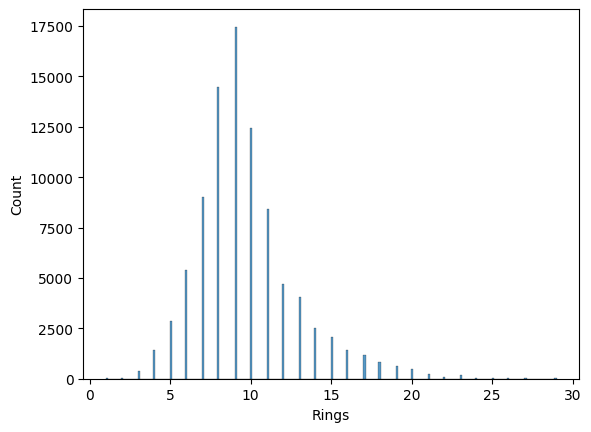

In [9]:
sns.histplot(train_df["Rings"])

In [10]:
train_df["Rings"].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

## Independent Variables

In [11]:
train_df["Sex"].value_counts(1)

Sex
I    0.365204
M    0.342405
F    0.292391
Name: proportion, dtype: float64

In [12]:
numeric_feature = [feature for feature in train_df if train_df[feature].dtype!= "O" and feature not in ["id", "Rings"]]
numeric_feature

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight']

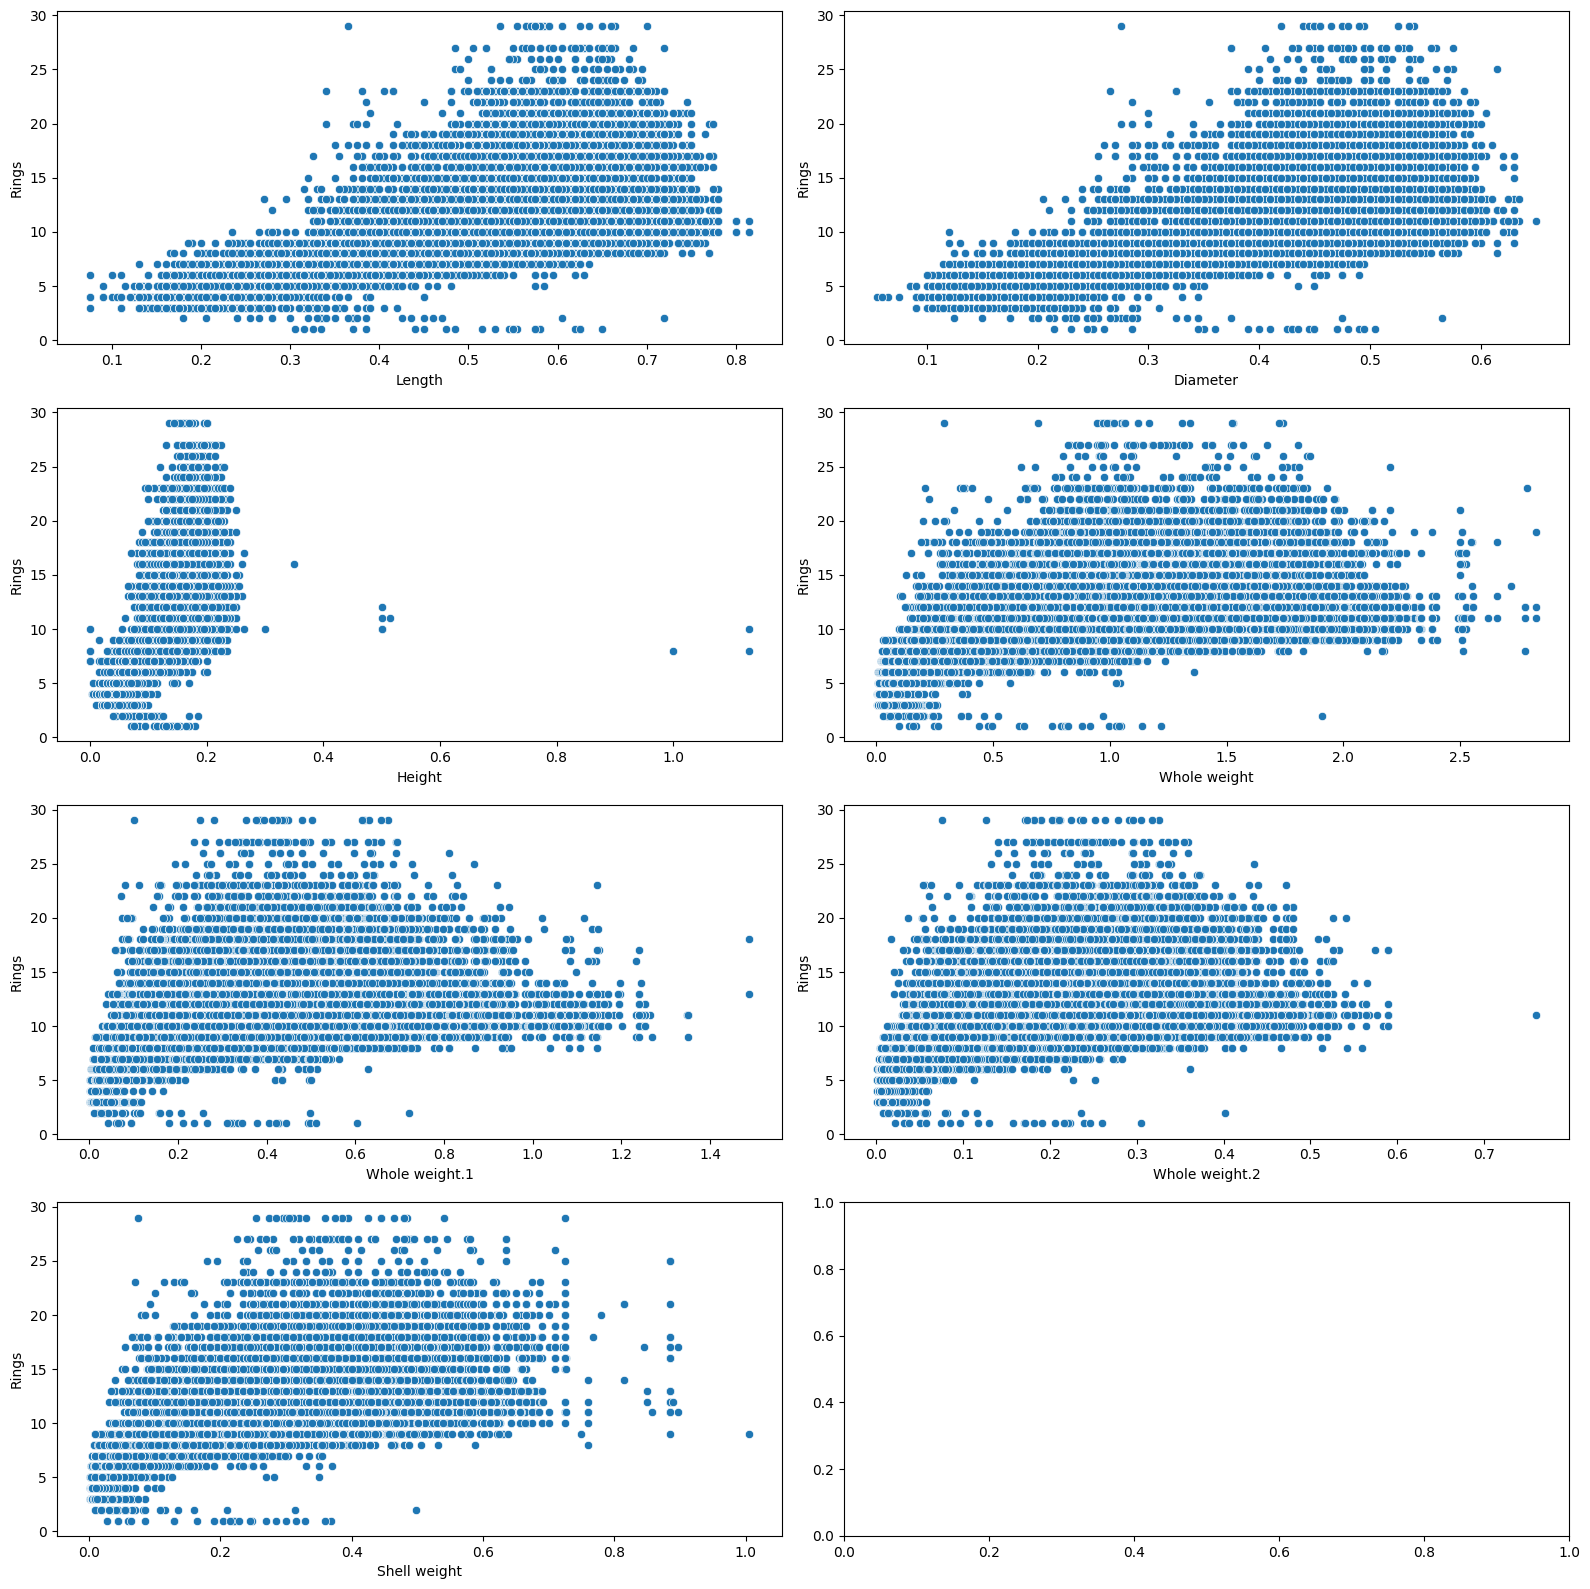

In [13]:
fig, axs = plt.subplots(4,2, figsize=(16,16))
for index, feature in enumerate(numeric_feature):
    sns.scatterplot(data=train_df, x=feature, y="Rings", ax= axs[index//2, index%2])
    
plt.tight_layout()
fig.show()

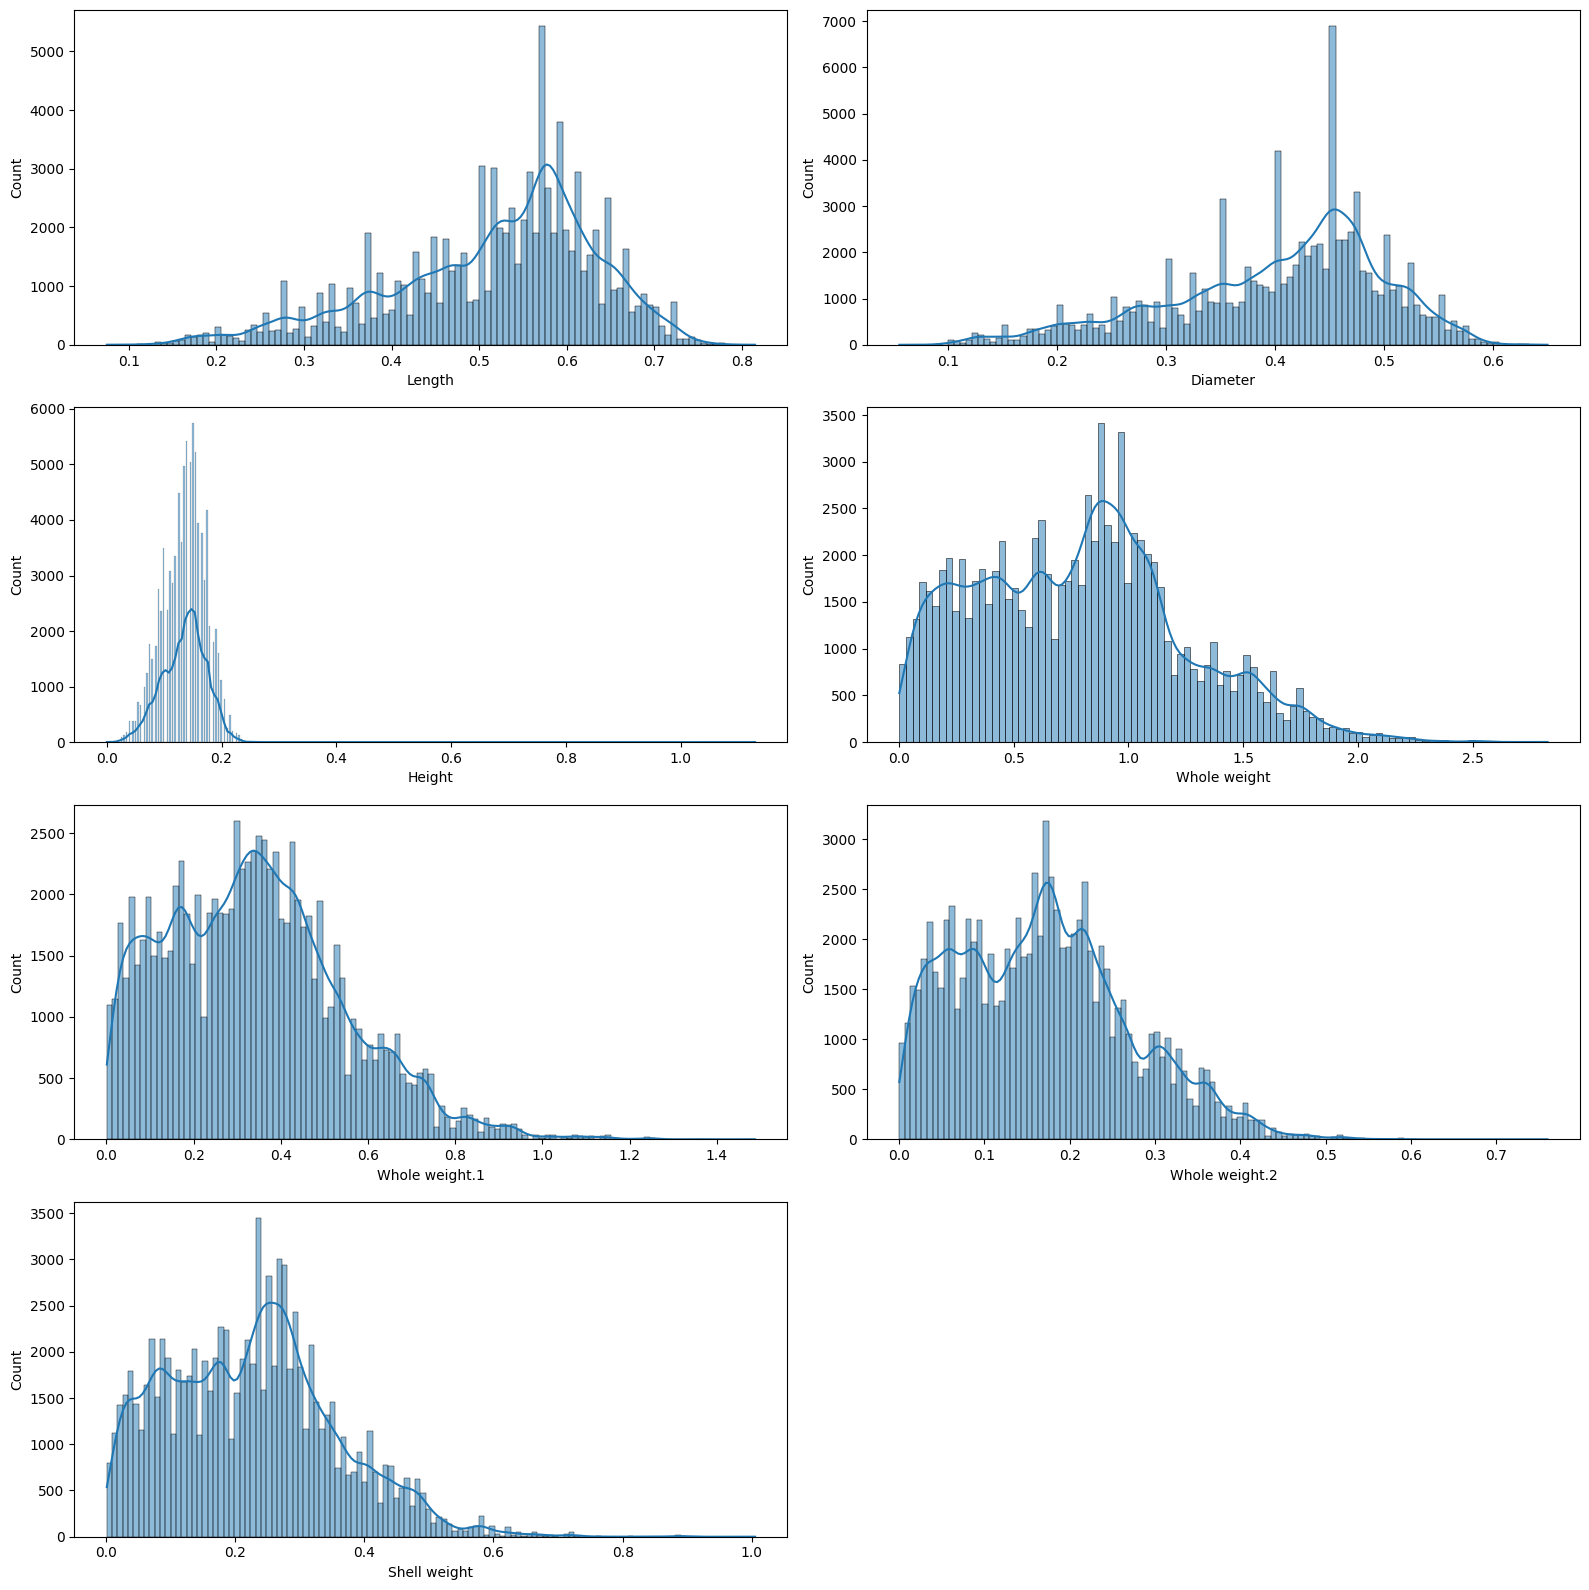

In [14]:
fig, axs = plt.subplots(4,2, figsize=(16,16))
for index, feature in enumerate(numeric_feature):
    sns.histplot(data=train_df, x=feature, ax= axs[index//2, index%2], kde=True)

for col in range(len(numeric_feature)%2, 2):
    axs[-1][col].remove()
plt.tight_layout()
fig.show()

* volume: I have length, height and diameter. 

- See if volume has something to do with rings


In [15]:
train_df["Radius"] = train_df["Diameter"]/2
train_df["volume"] = np.pi * (train_df["Radius"] ** 2) * train_df["Height"]
train_df.head(6)

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Radius,volume
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,0.2150,0.021783
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,0.2450,0.027343
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0.0550,0.000238
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0.2375,0.026581
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0.2125,0.018442
5,5,F,0.610,0.480,0.170,1.2010,0.5335,0.3135,0.3085,10,0.2400,0.030762


In [16]:
train_df[numeric_feature+["volume","Rings"]].corr()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,volume,Rings
Length,1.000000,0.989732,0.916094,0.931449,0.909609,0.913134,0.911073,0.920473,0.623786
Diameter,0.989732,1.000000,0.919618,0.933848,0.908466,0.914668,0.917871,0.932829,0.636832
Height,0.916094,0.919618,1.000000,0.902344,0.861769,0.886132,0.904019,0.942925,0.665772
Whole weight,0.931449,0.933848,0.902344,1.000000,0.971249,0.974319,0.964201,0.970500,0.617274
Whole weight.1,0.909609,0.908466,0.861769,0.971249,1.000000,0.949227,0.911800,0.937783,0.515067
Whole weight.2,0.913134,0.914668,0.886132,0.974319,0.949227,1.000000,0.937069,0.951433,0.588954
Shell weight,0.911073,0.917871,0.904019,0.964201,0.911800,0.937069,1.000000,0.956929,0.694766
volume,0.920473,0.932829,0.942925,0.970500,0.937783,0.951433,0.956929,1.000000,0.626801
Rings,0.623786,0.636832,0.665772,0.617274,0.515067,0.588954,0.694766,0.626801,1.000000


In [17]:
train_df[numeric_feature+["volume","Rings"]].corr()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,volume,Rings
Length,1.000000,0.989732,0.916094,0.931449,0.909609,0.913134,0.911073,0.920473,0.623786
Diameter,0.989732,1.000000,0.919618,0.933848,0.908466,0.914668,0.917871,0.932829,0.636832
Height,0.916094,0.919618,1.000000,0.902344,0.861769,0.886132,0.904019,0.942925,0.665772
Whole weight,0.931449,0.933848,0.902344,1.000000,0.971249,0.974319,0.964201,0.970500,0.617274
Whole weight.1,0.909609,0.908466,0.861769,0.971249,1.000000,0.949227,0.911800,0.937783,0.515067
Whole weight.2,0.913134,0.914668,0.886132,0.974319,0.949227,1.000000,0.937069,0.951433,0.588954
Shell weight,0.911073,0.917871,0.904019,0.964201,0.911800,0.937069,1.000000,0.956929,0.694766
volume,0.920473,0.932829,0.942925,0.970500,0.937783,0.951433,0.956929,1.000000,0.626801
Rings,0.623786,0.636832,0.665772,0.617274,0.515067,0.588954,0.694766,0.626801,1.000000


<Axes: xlabel='Sex', ylabel='Rings'>

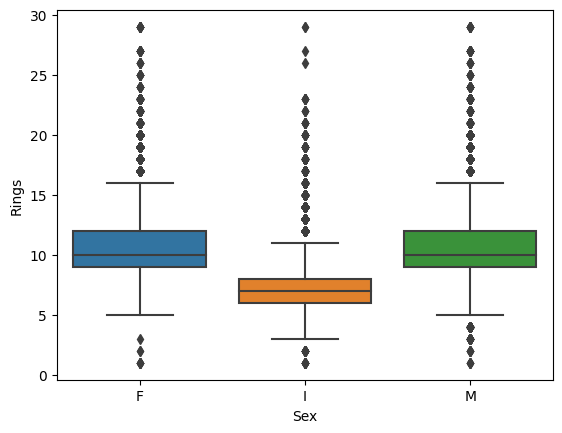

In [18]:
sns.boxplot(train_df, x="Sex", y="Rings")

# Preprocessing 

In [19]:
# reading a fresh copy

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# drop id 
train_df.drop(columns="id", inplace=True)


# seperating features and label
X = train_df.drop(columns="Rings")
y = train_df["Rings"]

# splitting train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((72492, 8), (72492,), (18123, 8), (18123,))

In [20]:
# encoding sex feature

ohe = OneHotEncoder(sparse_output=False,handle_unknown="ignore", drop="first")

ohe_train_numeric = pd.DataFrame(data = ohe.fit_transform(X_train["Sex"].to_frame()),
             columns = ohe.get_feature_names_out(),
             index = X_train.index)
ohe_train = pd.concat([ohe_train_numeric, X_train.drop(columns="Sex")], axis=1)


ohe_validate_numeric = pd.DataFrame(data = ohe.transform(X_val["Sex"].to_frame()),
             columns = ohe.get_feature_names_out(),
             index = X_val.index)
ohe_validate = pd.concat([ohe_validate_numeric, X_val.drop(columns="Sex")], axis=1)


In [21]:
# power transform

pt = PowerTransformer()

power_transformed_train = pd.DataFrame(data = pt.fit_transform(X_train[numeric_feature]),
                                   columns = pt.get_feature_names_out(),
                                   index=X_train.index)
power_transformed_train = pd.concat([X_train["Sex"],power_transformed_train],axis=1)

power_transformed_validate = pd.DataFrame(data = pt.transform(X_val[numeric_feature]),
                                   columns = pt.get_feature_names_out(),
                                   index=X_val.index)
power_transformed_validate = pd.concat([X_val["Sex"],power_transformed_validate],axis=1)

In [22]:
# also encoding our power transformed data

ohe_pt_train = pd.DataFrame(data = ohe.fit_transform(power_transformed_train["Sex"].to_frame()),
             columns = ohe.get_feature_names_out(),
             index = power_transformed_train.index)
power_transformed_train = pd.concat([ohe_pt_train, power_transformed_train.drop(columns="Sex")], axis=1)


ohe_pt_validate = pd.DataFrame(data = ohe.transform(power_transformed_validate["Sex"].to_frame()),
             columns = ohe.get_feature_names_out(),
             index = power_transformed_validate.index)
power_transformed_validate = pd.concat([ohe_pt_validate, power_transformed_validate.drop(columns="Sex")], axis=1)


# Model Building

In [23]:
poly = PolynomialFeatures(degree=(2))
poly_train = pd.DataFrame(poly.fit_transform(X_train[numeric_feature]),
                         columns=poly.get_feature_names_out(),
                         index=X_train.index)
poly_train = pd.concat([ohe_train_numeric, poly_train], axis=1)


poly_val = pd.DataFrame(poly.fit_transform(X_val[numeric_feature]),
                         columns=poly.get_feature_names_out(),
                         index=X_val.index)
poly_val = pd.concat([ohe_validate_numeric, poly_val], axis=1)
poly.get_feature_names_out()

array(['1', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Length^2',
       'Length Diameter', 'Length Height', 'Length Whole weight',
       'Length Whole weight.1', 'Length Whole weight.2',
       'Length Shell weight', 'Diameter^2', 'Diameter Height',
       'Diameter Whole weight', 'Diameter Whole weight.1',
       'Diameter Whole weight.2', 'Diameter Shell weight', 'Height^2',
       'Height Whole weight', 'Height Whole weight.1',
       'Height Whole weight.2', 'Height Shell weight', 'Whole weight^2',
       'Whole weight Whole weight.1', 'Whole weight Whole weight.2',
       'Whole weight Shell weight', 'Whole weight.1^2',
       'Whole weight.1 Whole weight.2', 'Whole weight.1 Shell weight',
       'Whole weight.2^2', 'Whole weight.2 Shell weight',
       'Shell weight^2'], dtype=object)

# Pipelines 

In [24]:

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('power_transformer', PowerTransformer())     # Apply power transformation
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

log_pipeline = make_pipeline(
            SimpleImputer(strategy="median"),
            FunctionTransformer(np.log1p,feature_names_out="one-to-one")) # the function is log(1+x)


def column_ratio(X):
    return(X[:,[0]]/X[:,[1]])

def ratio_name(function_transformer,feature_names_in):
    return ["ratio"]

ratio_pipeline=make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio,feature_names_out=ratio_name))


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="object")),
        ('cat', categorical_transformer, ['Sex']),
        ('log',log_pipeline, ['Whole weight','Whole weight.1','Whole weight.2','Shell weight']),
        ('ratio', ratio_pipeline, ['Whole weight.1','Whole weight'])])


# Combine preprocessing with modeling pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [25]:
X_train = train_df.drop(columns=['Rings'])
# y_train=train_df['Rings']
X_test = train_df.drop(columns=[])
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)
columns=pipeline.get_feature_names_out()
X_train_transformed = pd.DataFrame(X_train_transformed,columns=columns)
X_test_transformed = pd.DataFrame(X_test_transformed,columns=columns)

In [26]:
# X_train_transformed.shape, X_test_transformed.shape

# Define an evaluation method and test the storing method

In [27]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
key= user_secrets.get_secret("wandb")
wandb.login(key=key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [28]:
import wandb
from sklearn.model_selection import cross_val_score

    

def compute_cv_score_and_store(model, x, y, cv=[4], config=None, run_name=None, store_to_wandb=False):
    
    cv_scores = {}
    if store_to_wandb:
        with wandb.init(project="Kaggle-AbaReg", entity='kaggle-Abalone-Regression', config=config, name=run_name):
            for k in cv:
                # Compute cross-validation score for each fold
                cv_score = np.sqrt(-np.mean(cross_val_score(model, x, y, cv=k, n_jobs=-1, scoring='neg_mean_squared_log_error')))
                cv_scores[f'RMSLE CV{k}-score']= cv_score
                wandb.log({f'RMSLE CV{k}-score': cv_score})
        wandb.finish()
        
    else:
         for k in cv:
            # Compute cross-validation score for each fold
            cv_score = np.sqrt(-np.mean(cross_val_score(model, x, y, cv=k, n_jobs=-1, scoring='neg_mean_squared_log_error')))
            cv_scores[f'RMSLE CV{k}-score']= cv_score

        
    return cv_scores


# Optuna Search

In [29]:
import optuna
from optuna import Trial



In [30]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth",5,20)
    max_iter = trial.suggest_int("max_iter", 50,500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.9)
    l2 = trial.suggest_int("l2_regularization", 100,1000)
    
    model = HistGradientBoostingRegressor(random_state=42,
                                         max_depth=max_depth,
                                         max_iter=max_iter,
                                         learning_rate=learning_rate,
                                         l2_regularization=l2)
    score = np.sqrt(-np.mean(cross_val_score(model, power_transformed_train, y_train,
                                             cv=4, n_jobs=-1, scoring='neg_mean_squared_log_error')))
    return score
    

In [31]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100,show_progress_bar=True,n_jobs=-1)

In [32]:
# params = study.best_params
# params

In [33]:

# model = HistGradientBoostingRegressor(**params2, random_state=42)
# config= {"model": "Hist + PowerTransform + params2 finetuned",
#         "learning_rate": 0.1,
#         "max_depth": 8,
#         "max_iter": 200}
    
# compute_cv_score_and_store(model, power_transformed_train, y_train, cv=[4,10],
#                            config=config,run_name='Hist + PowerTransform + params2 finetuned',
#                            store_to_wandb=True)



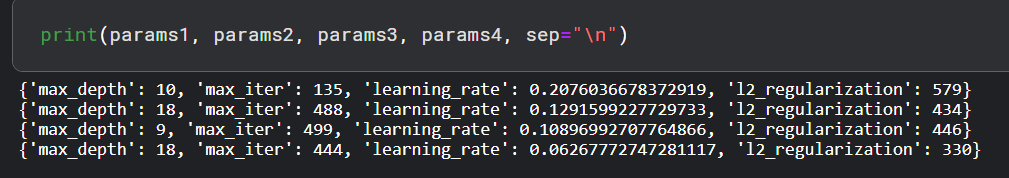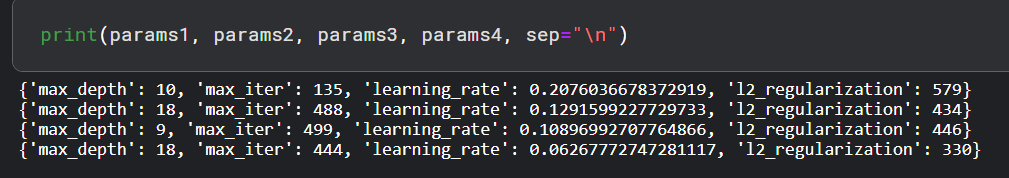

In [34]:
params1 = {"max_depth": 10, "max_iter": 135, "learning_rate": 0.2076036678372919, "l2_regularization": 579}
params2 = {"max_depth": 18,"max_iter": 488,"learning_rate": 0.1291599227729733,"l2_regularization": 434}
params3 = {"max_depth": 9, "max_iter": 499, "learning_rate": 0.10896992707764866, "l2_regularization": 446}
params4 = {"max_depth": 18, "max_iter": 444, "learning_rate": 0.06267772747281117, "l2_regularization": 330}

In [35]:
np.random.seed(42)
cv_estimators = [("param1", HistGradientBoostingRegressor(**params1)),
                ("param2", HistGradientBoostingRegressor(**params2)),
                ("param3", HistGradientBoostingRegressor(**params3)),
                ("param4", HistGradientBoostingRegressor(**params4))]

In [36]:
def objective_weights(trial):
    params = {
        "weight1": trial.suggest_int("weight1", 0.0, 5.0),
        "weight2": trial.suggest_int("weight2", 0.0, 5.0),
        "weight3": trial.suggest_int("weight3", 0.0, 5.0),
        "weight4": trial.suggest_int("weight4", 0.0, 5.0)       
    }
    model = VotingRegressor(cv_estimators,
                            weights=[params["weight1"], params["weight2"], params["weight3"], params["weight4"]])
    cv_score = np.sqrt(-np.mean(cross_val_score(model, power_transformed_train, y_train, cv=4, n_jobs=-1, scoring='neg_mean_squared_log_error')))
    return cv_score

In [37]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_weights, n_trials=100,show_progress_bar=True,n_jobs=-1)

In [38]:
# study.best_params

In [39]:
best_weight1 = {'weight1': 0, 'weight2': 2, 'weight3': 4, 'weight4': 1}
best_weight1
# 0.14985


best_weight2 = {'weight1': 2, 'weight2': 5, 'weight3': 3, 'weight4': 2}
# 0.14977 

In [40]:
# model = HistGradientBoostingRegressor(**params2, random_state=42)
# config= {"model": "Hist + PowerTransform + params2 finetuned",
#         "max_depth": 18,
#     "max_iter": 488,
#     "learning_rate": 0.1291599227729733,
#     "l2_regularization": 434}
    
# compute_cv_score_and_store(model, power_transformed_train, y_train, cv=[4,10],
#                            config=config,run_name='Hist + PowerTransform + params2 finetuned',
#                            store_to_wandb=False)

In [41]:
# model = VotingRegressor(cv_estimators,
#                             weights=[best_weight1["weight1"], best_weight1["weight2"], best_weight1["weight3"], best_weight1["weight4"]])


# cv_score4 = np.sqrt(-np.mean(cross_val_score(model, power_transformed_train, y_train, cv=4, n_jobs=-1, scoring='neg_mean_squared_log_error')))
# cv_score10 = np.sqrt(-np.mean(cross_val_score(model, power_transformed_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')))

# cv_score4, cv_score10 

In [42]:
# model = VotingRegressor(cv_estimators,
#                             weights=[best_weight1["weight1"], best_weight1["weight2"], best_weight1["weight3"], best_weight1["weight4"]])


# cv_score4 = np.sqrt(-np.mean(cross_val_score(model, X_train_transformed, y, cv=4, n_jobs=-1, scoring='neg_mean_squared_log_error')))
# cv_score10 = np.sqrt(-np.mean(cross_val_score(model,X_train_transformed, y, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')))

# cv_score4, cv_score10 

In [43]:

# model = VotingRegressor(cv_estimators,
#                             weights=[best_weight2["weight1"], best_weight2["weight2"], best_weight2["weight3"], best_weight2["weight4"]])


# cv_score4 = np.sqrt(-np.mean(cross_val_score(model, X_train_transformed, y, cv=4, n_jobs=-1, scoring='neg_mean_squared_log_error')))
# cv_score10 = np.sqrt(-np.mean(cross_val_score(model, X_train_transformed, y, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')))
# cv_score4,cv_score10

In [44]:

# model = VotingRegressor(cv_estimators,
#                             weights=[best_weight2["weight1"], best_weight2["weight2"], best_weight2["weight3"], best_weight2["weight4"]])


# cv_score4 = np.sqrt(-np.mean(cross_val_score(model, power_transformed_train, y_train, cv=4, n_jobs=-1, scoring='neg_mean_squared_log_error')))
# cv_score10 = np.sqrt(-np.mean(cross_val_score(model, power_transformed_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_squared_log_error')))
# cv_score4,cv_score10

# Creating Submission

In [45]:

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('power_transformer', PowerTransformer())     # Apply power transformation
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="object")),
        ('cat', categorical_transformer, ['Sex'])])


# Combine preprocessing with modeling pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [46]:
X_train = train_df.drop(columns=['Rings'])
y_train=train_df['Rings']
X_test = test_df.copy()
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)
columns=pipeline.get_feature_names_out()
X_train_transformed = pd.DataFrame(X_train_transformed,columns=columns)
X_test_transformed = pd.DataFrame(X_test_transformed,columns=columns)

In [47]:
# params = {
#     "max_depth": 18,
#     "max_iter": 488,
#     "learning_rate": 0.1291599227729733,
#     "l2_regularization": 434
# }
# model = HistGradientBoostingRegressor(**params, random_state=42)

model = VotingRegressor(cv_estimators,
                            weights=[best_weight2["weight1"], best_weight2["weight2"], best_weight2["weight3"], best_weight2["weight4"]])


model.fit(X_train_transformed, y)

VotingRegressor(estimators=[('param1',
                             HistGradientBoostingRegressor(l2_regularization=579,
                                                           learning_rate=0.2076036678372919,
                                                           max_depth=10,
                                                           max_iter=135)),
                            ('param2',
                             HistGradientBoostingRegressor(l2_regularization=434,
                                                           learning_rate=0.1291599227729733,
                                                           max_depth=18,
                                                           max_iter=488)),
                            ('param3',
                             HistGradientBoostingRegressor(l2_regularization=446,
                                                           learning_rate=0.10896992707764866,
                                                           max_depth=9,
                                                           max_iter=499)),
                            ('param4',
                             HistGradientBoostingRegressor(l2_regularization=330,
                                                           learning_rate=0.06267772747281117,
                                                           max_depth=18,
                                                           max_iter=444))],
                weights=[2, 5, 3, 2])

In [48]:
y_pred = model.predict(X_test_transformed)

output = pd.DataFrame({
    "id":test_df["id"],
    "Rings": y_pred})

output

,id,Rings
0,90615,9.835375
1,90616,9.629702
2,90617,10.121476
3,90618,10.426207
4,90619,7.566895
...,...,...
60406,151021,6.344836
60407,151022,9.401364
60408,151023,12.270808
60409,151024,13.695725


In [49]:
output.to_csv('submission.csv', index=False)